# **Import Libraries**



In [21]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [22]:
warnings.filterwarnings("ignore")

# **Reading Files**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/trash_images'

In [25]:
# Data Classes
print(os.listdir(data_path))

['cardboard', 'metal', 'glass', 'paper', 'plastic', 'trash']


In [26]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
trash_images,0
cardboard,403
metal,410
glass,501
paper,594
plastic,482
trash,137


In [27]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [28]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

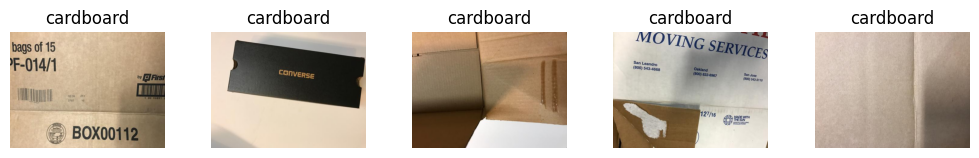

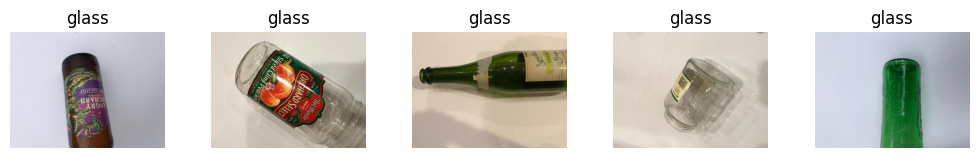

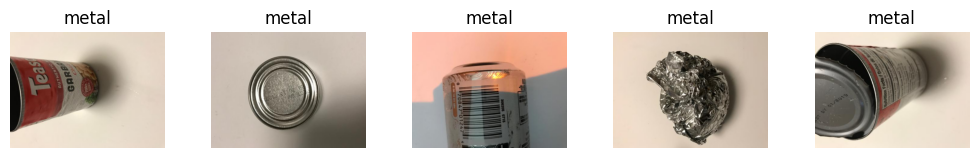

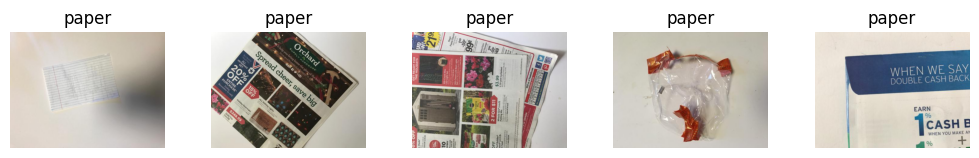

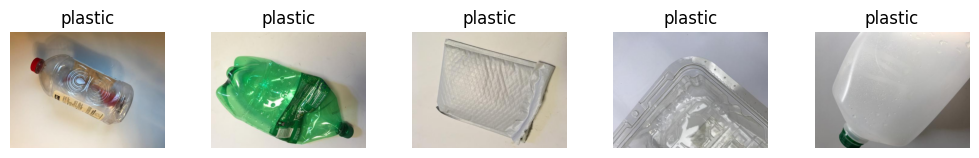

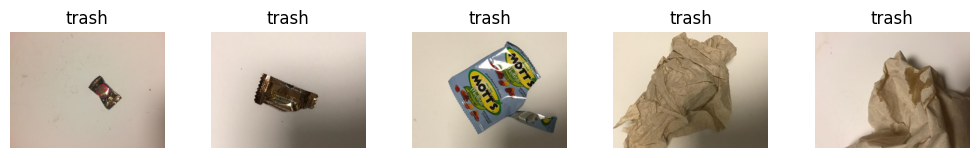

In [29]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

# **Generate Data**

In [30]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [31]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

# **Split Train & Test Files**

In [32]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [33]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


# **Network Architecture**

In [34]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

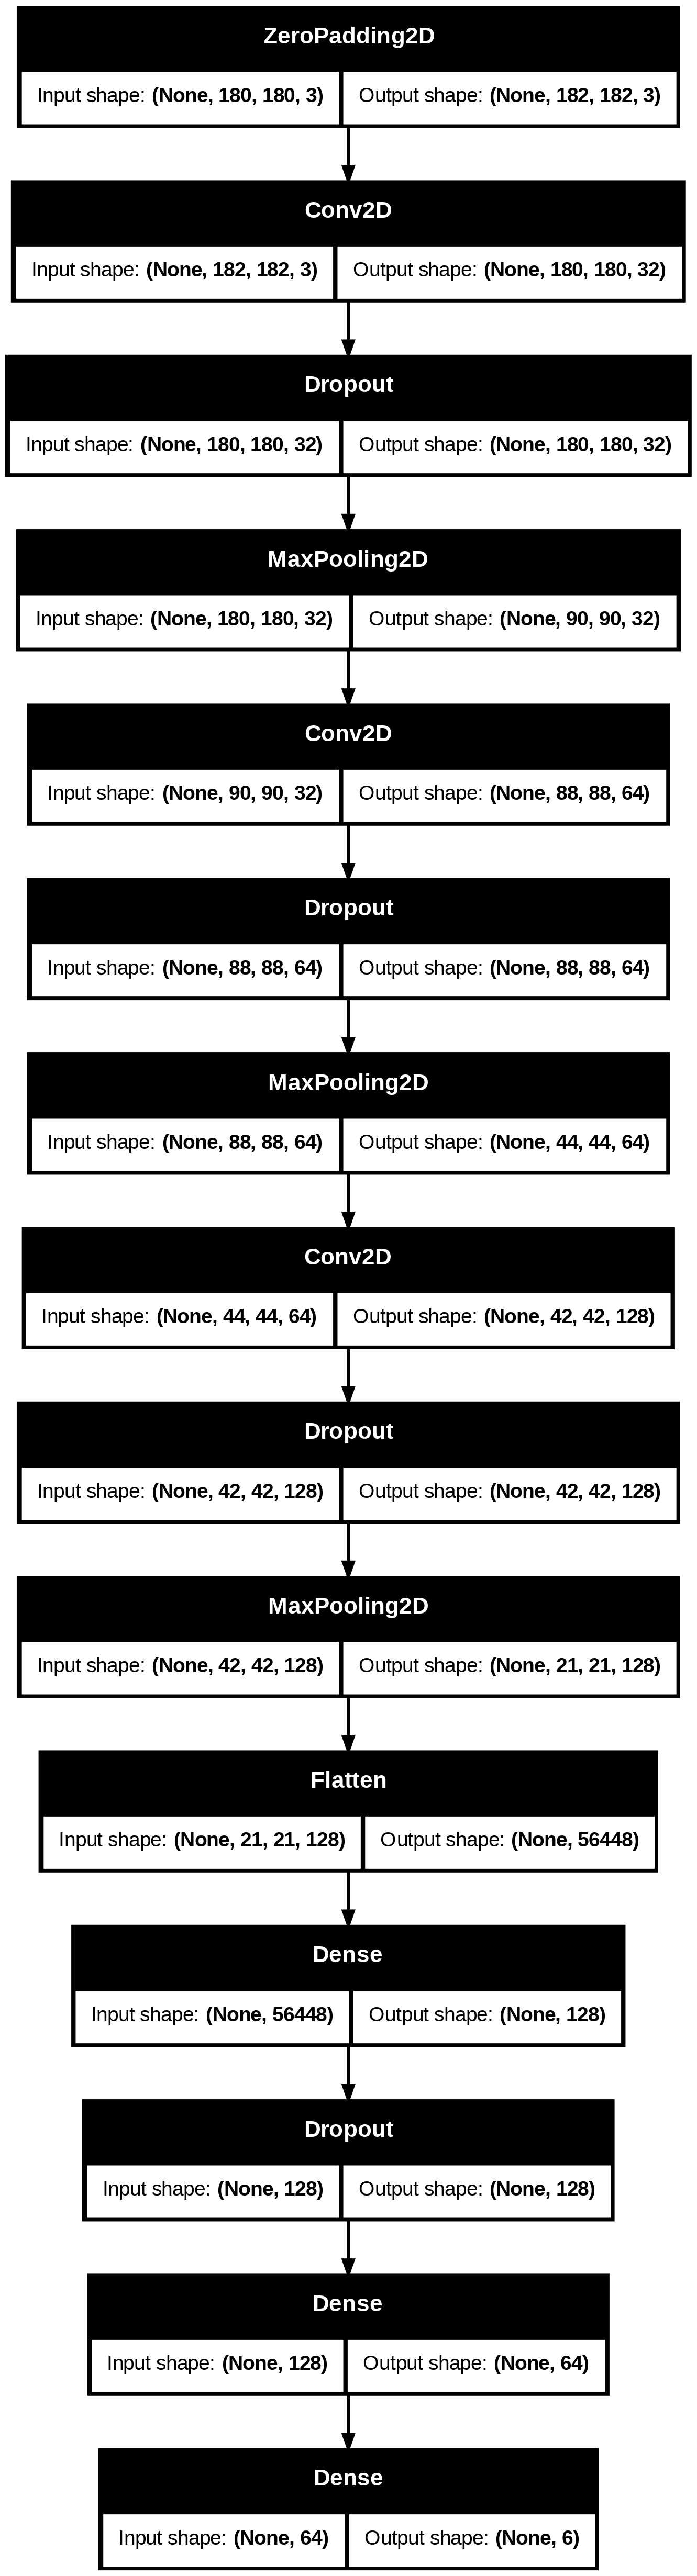

In [35]:
plot_model(model, show_shapes=True, show_layer_names=False)

# **Compiler**

In [36]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [37]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [38]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

# **Train Model**

In [40]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=400,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - categorical_accuracy: 0.2583 - loss: 1.9095

72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 444ms/step - categorical_accuracy: 0.2583 - loss: 1.9074 - val_categorical_accuracy: 0.2865 - val_loss: 1.7208 - learning_rate: 0.0010
Epoch 2/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - categorical_accuracy: 0.2992 - loss: 1.6348

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.2992 - loss: 1.6349 - val_categorical_accuracy: 0.2414 - val_loss: 1.6675 - learning_rate: 0.0010
Epoch 3/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - categorical_accuracy: 0.2719 - loss: 1.6346

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 377ms/step - categorical_accuracy: 0.2722 - loss: 1.6343 - val_categorical_accuracy: 0.3263 - val_loss: 1.6385 - learning_rate: 0.0010
Epoch 4/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - categorical_accuracy: 0.3710 - loss: 1.5474

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - categorical_accuracy: 0.3708 - loss: 1.5474 - val_categorical_accuracy: 0.3979 - val_loss: 1.6143 - learning_rate: 0.0010
Epoch 5/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - categorical_accuracy: 0.3777 - loss: 1.5155

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 387ms/step - categorical_accuracy: 0.3777 - loss: 1.5155 - val_categorical_accuracy: 0.4668 - val_loss: 1.5038 - learning_rate: 0.0010
Epoch 6/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - categorical_accuracy: 0.4238 - loss: 1.4324

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - categorical_accuracy: 0.4239 - loss: 1.4323 - val_categorical_accuracy: 0.4907 - val_loss: 1.4577 - learning_rate: 0.0010
Epoch 7/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - categorical_accuracy: 0.4485 - loss: 1.3845

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - categorical_accuracy: 0.4485 - loss: 1.3845 - val_categorical_accuracy: 0.4748 - val_loss: 1.4300 - learning_rate: 0.0010
Epoch 8/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 392ms/step - categorical_accuracy: 0.4561 - loss: 1.3759 - val_categorical_accuracy: 0.4615 - val_loss: 1.4539 - learning_rate: 0.0010
Epoch 9/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - categorical_accuracy: 0.4493 - loss: 1.3626

72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 365ms/step - categorical_accuracy: 0.4493 - loss: 1.3628 - val_categorical_accuracy: 0.4987 - val_loss: 1.3671 - learning_rate: 0.0010
Epoch 10/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - categorical_accuracy: 0.4788 - loss: 1.2978 - val_categorical_accuracy: 0.4801 - val_loss: 1.4133 - learning_rate: 0.0010
Epoch 11/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - categorical_accuracy: 0.4783 - loss: 1.3230

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - categorical_accuracy: 0.4783 - loss: 1.3231 - val_categorical_accuracy: 0.4642 - val_loss: 1.3601 - learning_rate: 0.0010
Epoch 12/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - categorical_accuracy: 0.4847 - loss: 1.3234

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.4848 - loss: 1.3234 - val_categorical_accuracy: 0.5199 - val_loss: 1.3019 - learning_rate: 0.0010
Epoch 13/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - categorical_accuracy: 0.5234 - loss: 1.2497 - val_categorical_accuracy: 0.4881 - val_loss: 1.3258 - learning_rate: 0.0010
Epoch 14/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - categorical_accuracy: 0.5153 - loss: 1.2730

72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - categorical_accuracy: 0.5153 - loss: 1.2729 - val_categorical_accuracy: 0.5305 - val_loss: 1.2922 - learning_rate: 0.0010
Epoch 15/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - categorical_accuracy: 0.5055 - loss: 1.2656 - val_categorical_accuracy: 0.5676 - val_loss: 1.3234 - learning_rate: 0.0010
Epoch 16/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - categorical_accuracy: 0.5368 - loss: 1.2011

72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - categorical_accuracy: 0.5366 - loss: 1.2017 - val_categorical_accuracy: 0.5756 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 17/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 375ms/step - categorical_accuracy: 0.5285 - loss: 1.2560 - val_categorical_accuracy: 0.5491 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 18/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - categorical_accuracy: 0.5208 - loss: 1.2558

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - categorical_accuracy: 0.5208 - loss: 1.2554 - val_categorical_accuracy: 0.5676 - val_loss: 1.2356 - learning_rate: 0.0010
Epoch 19/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.5385 - loss: 1.2350 - val_categorical_accuracy: 0.5066 - val_loss: 1.3093 - learning_rate: 0.0010
Epoch 20/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - categorical_accuracy: 0.5529 - loss: 1.1918 - val_categorical_accuracy: 0.5411 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 21/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - categorical_accuracy: 0.5638 - loss: 1.1583 - val_categorical_accuracy: 0.5995 - val_loss: 1.2529 - learning_rate: 0.0010
Epoch 22/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 364ms/step - categorical_accuracy: 0.5574 - loss: 1.1587 - val_categorical_accuracy: 0.5809 - val_loss: 1.3024 - learning_rate: 0.0010
Epoch 23/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - categorical_accuracy: 0.5510 - loss: 1.1598

72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - categorical_accuracy: 0.5511 - loss: 1.1595 - val_categorical_accuracy: 0.6286 - val_loss: 1.1730 - learning_rate: 0.0010
Epoch 24/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step - categorical_accuracy: 0.6094 - loss: 1.0469 - val_categorical_accuracy: 0.5915 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 25/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - categorical_accuracy: 0.5688 - loss: 1.1063 - val_categorical_accuracy: 0.5703 - val_loss: 1.2506 - learning_rate: 0.0010
Epoch 26/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - categorical_accuracy: 0.5698 - loss: 1.1551 - val_categorical_accuracy: 0.5385 - val_loss: 1.1971 - learning_rate: 0.0010
Epoch 27/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 371ms/step - categorical_accuracy: 0.5831 - loss: 1.0865 - val_categorical_accuracy: 0.5066 - val_loss: 1.2391 - learning_rate: 0.0010
Epoch 28/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - categorical_accuracy: 0.5701 - loss: 1.1058

72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - categorical_accuracy: 0.5702 - loss: 1.1059 - val_categorical_accuracy: 0.6340 - val_loss: 1.1675 - learning_rate: 0.0010
Epoch 29/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.5705 - loss: 1.1530 - val_categorical_accuracy: 0.6207 - val_loss: 1.1977 - learning_rate: 0.0010
Epoch 30/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - categorical_accuracy: 0.5826 - loss: 1.1201 - val_categorical_accuracy: 0.4881 - val_loss: 1.2890 - learning_rate: 0.0010
Epoch 31/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.5747 - loss: 1.1066 - val_categorical_accuracy: 0.5995 - val_loss: 1.1934 - learning_rate: 0.0010
Epoch 32/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - categorical_accuracy: 0.5981 - loss: 1.0810 - val_categorical_accuracy: 0.5305 - val_loss: 1.2355 - learning_rate: 0.0010
Epoch 33/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - categorical_accuracy: 0.5727 - loss: 1.1208 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.5877 - loss: 1.0750 - val_categorical_accuracy: 0.6472 - val_loss: 1.1109 - learning_rate: 0.0010
Epoch 36/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step - categorical_accuracy: 0.6260 - loss: 0.9939 - val_categorical_accuracy: 0.5809 - val_loss: 1.2131 - learning_rate: 0.0010
Epoch 37/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - categorical_accuracy: 0.6094 - loss: 1.0360 - val_categorical_accuracy: 0.5809 - val_loss: 1.2363 - learning_rate: 0.0010
Epoch 38/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.6009 - loss: 1.0263 - val_categorical_accuracy: 0.5836 - val_loss: 1.1480 - learning_rate: 0.0010
Epoch 39/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - categorical_accuracy: 0.6134 - loss: 1.0738 - val_categorical_accuracy: 0.6180 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 40/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - categorical_accuracy: 0.6015 - loss: 1.0420

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.6016 - loss: 1.0418 - val_categorical_accuracy: 0.6393 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 41/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 363ms/step - categorical_accuracy: 0.6359 - loss: 0.9587 - val_categorical_accuracy: 0.6260 - val_loss: 1.1710 - learning_rate: 0.0010
Epoch 42/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - categorical_accuracy: 0.6088 - loss: 1.0019

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - categorical_accuracy: 0.6088 - loss: 1.0023 - val_categorical_accuracy: 0.6552 - val_loss: 1.0708 - learning_rate: 0.0010
Epoch 43/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - categorical_accuracy: 0.6072 - loss: 1.0289 - val_categorical_accuracy: 0.6499 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 44/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.6316 - loss: 0.9574 - val_categorical_accuracy: 0.6313 - val_loss: 1.0868 - learning_rate: 0.0010
Epoch 45/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step - categorical_accuracy: 0.6197 - loss: 0.9973 - val_categorical_accuracy: 0.6499 - val_loss: 1.0837 - learning_rate: 0.0010
Epoch 46/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - categorical_accuracy: 0.6295 - loss: 0.9957 - val_categorical_accuracy: 0.6260 - val_loss: 1.1569 - learning_rate: 0.0010
Epoch 47/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - categorical_accuracy: 0.6221 - loss: 1.0108 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 518ms/step - categorical_accuracy: 0.5852 - loss: 1.0210 - val_categorical_accuracy: 0.6366 - val_loss: 1.0671 - learning_rate: 0.0010
Epoch 50/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - categorical_accuracy: 0.6348 - loss: 0.9354 - val_categorical_accuracy: 0.6313 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 51/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - categorical_accuracy: 0.6481 - loss: 0.9141

72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - categorical_accuracy: 0.6481 - loss: 0.9143 - val_categorical_accuracy: 0.6631 - val_loss: 1.0590 - learning_rate: 0.0010
Epoch 52/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - categorical_accuracy: 0.6185 - loss: 0.9873

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 388ms/step - categorical_accuracy: 0.6185 - loss: 0.9873 - val_categorical_accuracy: 0.6419 - val_loss: 1.0158 - learning_rate: 0.0010
Epoch 53/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - categorical_accuracy: 0.6233 - loss: 1.0358 - val_categorical_accuracy: 0.6393 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 54/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 384ms/step - categorical_accuracy: 0.6602 - loss: 0.9494 - val_categorical_accuracy: 0.5358 - val_loss: 1.1932 - learning_rate: 0.0010
Epoch 55/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - categorical_accuracy: 0.6087 - loss: 1.0221

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - categorical_accuracy: 0.6089 - loss: 1.0215 - val_categorical_accuracy: 0.6552 - val_loss: 1.0086 - learning_rate: 0.0010
Epoch 56/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step - categorical_accuracy: 0.6496 - loss: 0.9333 - val_categorical_accuracy: 0.6525 - val_loss: 1.0685 - learning_rate: 0.0010
Epoch 57/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.6259 - loss: 0.9665 - val_categorical_accuracy: 0.6578 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 58/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - categorical_accuracy: 0.5996 - loss: 1.0068

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 381ms/step - categorical_accuracy: 0.6000 - loss: 1.0059 - val_categorical_accuracy: 0.6605 - val_loss: 0.9991 - learning_rate: 0.0010
Epoch 59/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step - categorical_accuracy: 0.6556 - loss: 0.8970 - val_categorical_accuracy: 0.6313 - val_loss: 1.0463 - learning_rate: 0.0010
Epoch 60/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - categorical_accuracy: 0.6585 - loss: 0.9411

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step - categorical_accuracy: 0.6586 - loss: 0.9410 - val_categorical_accuracy: 0.6790 - val_loss: 0.9941 - learning_rate: 0.0010
Epoch 61/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 375ms/step - categorical_accuracy: 0.6649 - loss: 0.9138 - val_categorical_accuracy: 0.6552 - val_loss: 1.0490 - learning_rate: 0.0010
Epoch 62/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step - categorical_accuracy: 0.6634 - loss: 0.9010 - val_categorical_accuracy: 0.6525 - val_loss: 1.0256 - learning_rate: 0.0010
Epoch 63/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - categorical_accuracy: 0.6598 - loss: 0.9401 - val_categorical_accuracy: 0.6684 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 64/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - categorical_accuracy: 0.6609 - loss: 0.8844 - val_categorical_accuracy: 0.6950 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 65/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 384ms/step - categorical_accuracy: 0.6631 - loss: 0.8709 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - categorical_accuracy: 0.6429 - loss: 0.9533 - val_categorical_accuracy: 0.6525 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 68/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.6604 - loss: 0.8983 - val_categorical_accuracy: 0.6605 - val_loss: 1.0980 - learning_rate: 0.0010
Epoch 69/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step - categorical_accuracy: 0.6712 - loss: 0.9085 - val_categorical_accuracy: 0.6472 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 70/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - categorical_accuracy: 0.6880 - loss: 0.8317

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 388ms/step - categorical_accuracy: 0.6879 - loss: 0.8319 - val_categorical_accuracy: 0.6764 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 71/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 391ms/step - categorical_accuracy: 0.6963 - loss: 0.8199 - val_categorical_accuracy: 0.6446 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 72/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - categorical_accuracy: 0.6445 - loss: 0.9134 - val_categorical_accuracy: 0.6233 - val_loss: 1.1061 - learning_rate: 0.0010
Epoch 73/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 387ms/step - categorical_accuracy: 0.6642 - loss: 0.8601 - val_categorical_accuracy: 0.6897 - val_loss: 0.9748 - learning_rate: 0.0010
Epoch 74/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.6826 - loss: 0.8461 - val_categorical_accuracy: 0.6711 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 75/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - categorical_accuracy: 0.6905 - loss: 0.8576

72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - categorical_accuracy: 0.6901 - loss: 0.8580 - val_categorical_accuracy: 0.6976 - val_loss: 0.9193 - learning_rate: 0.0010
Epoch 76/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - categorical_accuracy: 0.6896 - loss: 0.8089 - val_categorical_accuracy: 0.6737 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 77/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - categorical_accuracy: 0.6957 - loss: 0.8049 - val_categorical_accuracy: 0.6764 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 78/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.6842 - loss: 0.8846 - val_categorical_accuracy: 0.7056 - val_loss: 0.9524 - learning_rate: 0.0010
Epoch 79/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.6994 - loss: 0.8147 - val_categorical_accuracy: 0.6499 - val_loss: 1.0149 - learning_rate: 0.0010
Epoch 80/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - categorical_accuracy: 0.6901 - loss: 0.8470 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.6917 - loss: 0.8201 - val_categorical_accuracy: 0.6976 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 85/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - categorical_accuracy: 0.7246 - loss: 0.7583 - val_categorical_accuracy: 0.6817 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 86/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.7000 - loss: 0.8248 - val_categorical_accuracy: 0.6525 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 87/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - categorical_accuracy: 0.7087 - loss: 0.8001

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - categorical_accuracy: 0.7086 - loss: 0.8001 - val_categorical_accuracy: 0.7294 - val_loss: 0.8494 - learning_rate: 0.0010
Epoch 88/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - categorical_accuracy: 0.7215 - loss: 0.7711 - val_categorical_accuracy: 0.6870 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 89/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - categorical_accuracy: 0.6999 - loss: 0.8077 - val_categorical_accuracy: 0.7135 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 90/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - categorical_accuracy: 0.7139 - loss: 0.7675 - val_categorical_accuracy: 0.7003 - val_loss: 0.9082 - learning_rate: 0.0010
Epoch 91/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - categorical_accuracy: 0.7447 - loss: 0.7209 - val_categorical_accuracy: 0.6950 - val_loss: 0.9195 - learning_rate: 0.0010
Epoch 92/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - categorical_accuracy: 0.7176 - loss: 0.7560 - val_categorical

# **Avaliação Final**

## **Model Evaluation**

In [55]:
'''----- ACURÁCIA -----'''

best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is (test data): {best_score}")

best_score = max(history.history['categorical_accuracy'] )
print(f"Best Validation score is (train data): {best_score}")

Best Validation score is (test data): 0.7294429540634155
Best Validation score is (train data): 0.7311627864837646


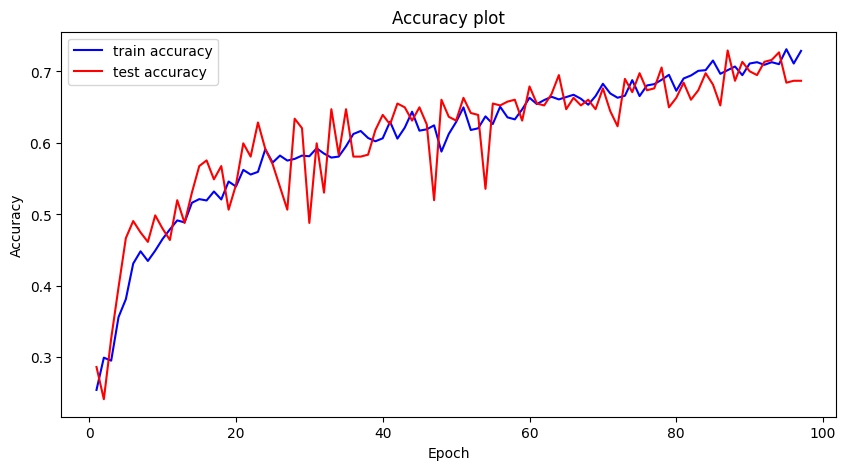

In [56]:
'''----- ACURÁCIA -----'''

# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

## **Using Model**

In [57]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

#### **CARDBOARD**

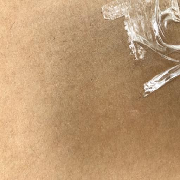

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/cardboard/cardboard17.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [59]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
cardboard


#### **PAPER**

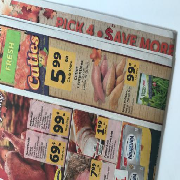

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/paper/paper73.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [61]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
paper


#### **GLASS**

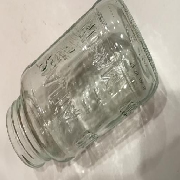

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/glass/glass35.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [63]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
glass


#### **METAL**

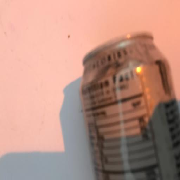

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/metal/metal355.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [65]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
metal


#### **PLASTIC**

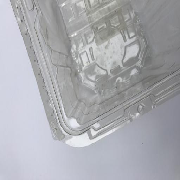

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/plastic/plastic66.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [67]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
plastic


#### **TRASH**

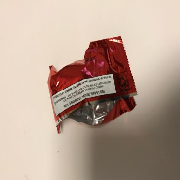

In [ ]:
img = utils.load_img(
    '/content/drive/MyDrive/Colab_Notebooks/trash_images/trash/trash9.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [69]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
trash


## **Matriz de Confusão**

Avaliando o modelo no jogo de teste...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - categorical_accuracy: 0.6891 - loss: 0.8662

Acurácia Categórica no Jogo de Teste: 68.70%
Loss no Jogo de Teste: 0.8788
Calculando previsões para a matriz de confusão...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

   cardboard       0.15      0.13      0.14        60
       glass       0.18      0.15      0.16        75
       metal       0.16      0.23      0.19        61
       paper       0.22      0.21      0.22        89
     plastic       0.18      0.14      0.16        72
       trash       0.03      0.05      0.04        20

    accuracy                           0.17       377
   macro avg       0.15      0.15      0.15       377
weighted avg       0.17      0.17      0.17       377


--- Gerando a Matriz de Confusão ---


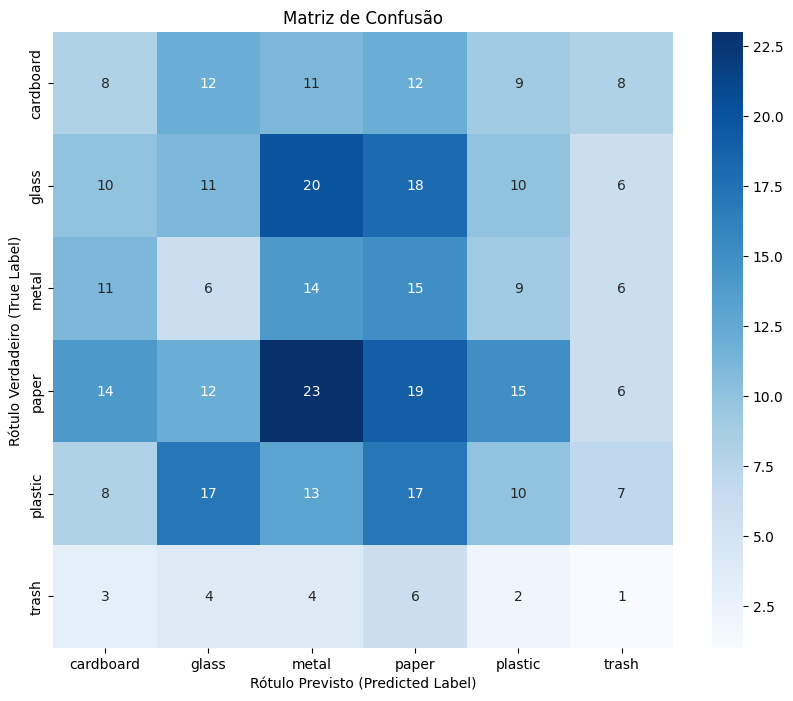

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Avaliação da Acurácia Categórica
print("Avaliando o modelo no jogo de teste...")
# O model.evaluate retorna [loss, accuracy]
test_loss, test_acc = model.evaluate(test_data, steps=len(test_data))

print(f"\nAcurácia Categórica no Jogo de Teste: {test_acc*100:.2f}%")
print(f"Loss no Jogo de Teste: {test_loss:.4f}")

# Obter Previsões e Rótulos Verdadeiros
print("Calculando previsões para a matriz de confusão...")

# Obter as probabilidades previstas pelo modelo
y_pred_probs = model.predict(test_data, steps=len(test_data))

# Converter as probabilidades no rótulo da classe (o índice com maior probabilidade)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obter os rótulos verdadeiros diretamente do gerador de dados
y_true = test_data.classes

# Obter os nomes das classes
class_names = list(test_data.class_indices.keys())

print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusão
print("\n--- Gerando a Matriz de Confusão ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro (True Label)')
plt.xlabel('Rótulo Previsto (Predicted Label)')
plt.show()